In [1]:
import numpy as np
from myplotstyle import plt

from easyquery import Query, QueryMaker
import SAGA
from SAGA import ObjectCuts as C
from SAGA import HostCuts as H

import io
from astropy.io import ascii
from astropy.table import Table
from scipy.stats import norm

In [2]:
print(SAGA.__version__)
saga = SAGA.QuickStart()

3.0.0
SAGA `shared_dir` set to /home/yymao/Dropbox/Work/SAGA
SAGA `local_dir`  set to /home/yymao/Documents/Work/Data/SAGA


In [3]:
base = H.paper3.filter(saga.object_catalog.load_combined_base_catalog())
nhosts = len(np.unique(base["HOSTID"]))
assert nhosts == 101

In [4]:
sats = C.is_sat.filter(base)
sats_maybe_all = Query(~C.has_spec, "p_sat_corrected > 0", C.sat_rcut).filter(base)

In [5]:
hosts = saga.host_catalog.load(include_stats=True, query="paper3")
lg_like_hosts = Query("NEARBY_MW_COUNT_1 == 1").filter(hosts)

### Quenched fraction

In [6]:
fq_lg = ascii.read(format="fast_tab", names=["log_sm", "fq", "fq_ue", "fq_le"], data_start=0,
    table="""3.49	1.00	1.00	0.77
4.49	1.00	1.00	0.90
5.49	0.94	0.96	0.83
6.49	1.00	1.00	0.77
7.49	0.80	0.88	0.54
8.49	0.66	0.81	0.38
9.18	0.00	0.60	0.00
""")

fq_tinker = ascii.read(format="fast_tab", names=["log_sm0", "fq", "log_sm1",  "fq_ue", "log_sm2", "fq_le"], data_start=0,
    table="""9.7632	0.0625	9.7655	0.0455	9.7633	0.0788
9.8511	0.1149	9.8510	0.0986	9.8511	0.1312
9.9459	0.1340	9.9459	0.1170	9.9459	0.1503
10.0479	0.1835	10.0479	0.1637	10.0480	0.2019
10.1477	0.2514	10.1476	0.2295	10.1477	0.2734
10.2449	0.2790	10.2472	0.2563	10.2473	0.3010
10.3494	0.3618	10.3493	0.3363	10.3495	0.3859
10.4468	0.4433	10.4467	0.4142	10.4445	0.4709
10.5488	0.4666	10.5487	0.4340	10.5489	0.4985
10.6485	0.5381	10.6484	0.5033	10.6486	0.5728
10.7458	0.5812	10.7481	0.5437	10.7483	0.6188
10.8503	0.6471	10.8501	0.5982	10.8504	0.6938
10.9523	0.7079	10.9522	0.6526	10.9525	0.7632
11.0495	0.7249	11.0493	0.6575	11.0521	0.7929
11.1397	0.7517	11.1394	0.6695	11.1399	0.8346
11.2347	0.8211	11.2319	0.6943	11.2327	0.9472
""")
fq_tinker["log_sm"] = (fq_tinker["log_sm0"] + fq_tinker["log_sm1"] + fq_tinker["log_sm2"]) / 3
fq_tinker["log_sm"] += 0.03  # Chabrier to Kroupa IMF conversion

# Geha 2012
fq_geha = ascii.read(format="fast_tab", names=["log_sm", "fq","fq_e"], data_start=0,
    table="""9.9	0.084	0.0052
9.7	0.031	0.0032
9.5	0.017	0.0023
9.3	0.007	0.0016
9.1	0.002	0.0014
8.9	0.000	0.0019
8.7	0.000	0.0028
8.5	0.000	0.0043
8.3	0.000	0.0065
8.1	0.000	0.0091
7.8	0.000	0.0093
7.3	0.000	0.0193
""")
fq_geha["log_sm"] += 0.03  # Chabrier to Kroupa IMF conversion
fq_geha["fq_ue"] = fq_geha["fq"] + fq_geha["fq_e"]
fq_geha["fq_le"] = np.maximum(0, fq_geha["fq"] - fq_geha["fq_e"])

In [7]:
def write_latex_table(t, formats=None, write_to=None, display=True):
    if formats is None:
        formats = {}
    if not isinstance(formats, dict):
        formats = {c: f for c, f in zip(t.colnames, formats, strict=True)}

    fp = io.StringIO()
    t.write(fp, format="ascii.latex", formats=formats)
    lines = fp.getvalue().splitlines()
    lines[-3] = lines[-3].rstrip("\\")

    fp = io.StringIO()
    fp.write("\n".join(lines[3:-2]))
    fp.write("\n")
    out = fp.getvalue()

    if write_to:
        with open(write_to, "w") as fp:
            fp.write(out)

    if display:
        print(out)

9.38 & 0.135 & 0.135 & 0.049 \\
8.62 & 0.160 & 0.157 & 0.053 \\
8.15 & 0.259 & 0.235 & 0.061 \\
7.83 & 0.335 & 0.269 & 0.063 \\
7.57 & 0.408 & 0.275 & 0.061 \\
7.31 & 0.562 & 0.333 & 0.056 \\
6.95 & 0.792 & 0.250 & 0.026 



/tmp/ipykernel_12237/2947171846.py:22: RuntimeWarning: invalid value encountered in divide
  p = n_q_imc/n_all_imc


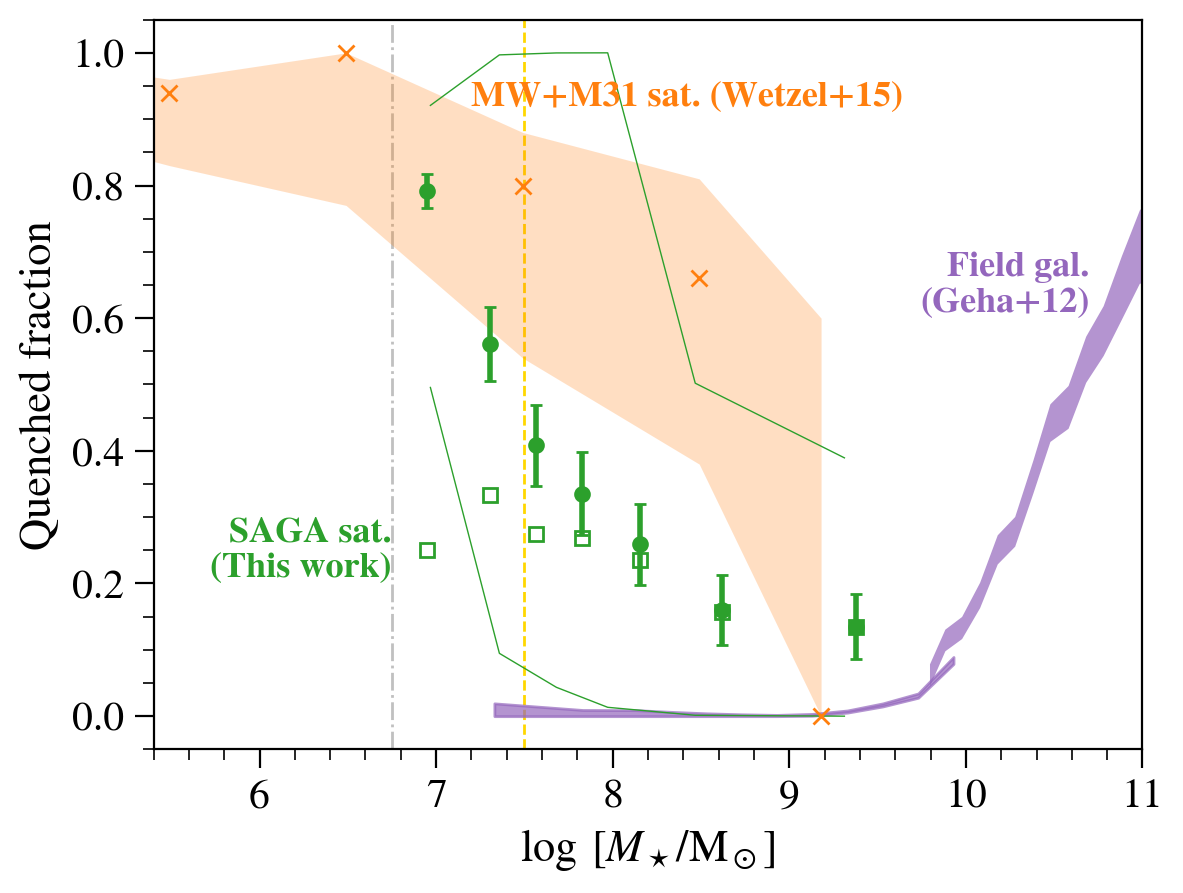

In [8]:
plt.fill_between(fq_tinker["log_sm"], fq_tinker["fq_le"], fq_tinker["fq_ue"], color="C4", alpha=0.7, lw=0, rasterized=True)
plt.fill_between(fq_geha["log_sm"], fq_geha["fq_le"], fq_geha["fq_ue"], color="C4", alpha=0.7, rasterized=True)

plt.errorbar(fq_lg["log_sm"], fq_lg["fq"], marker='x', ls="", c="C1", ms=6)
plt.fill_between(fq_lg["log_sm"], fq_lg["fq_le"], fq_lg["fq_ue"], color="C1", alpha=0.25, lw=0, rasterized=True)

pbins = np.linspace(0, 100, 8)
log_sm = np.concatenate([sats['log_sm']])
log_sm = log_sm[log_sm >= 6.75]
bins = np.percentile(log_sm, pbins)
x = np.percentile(log_sm, (pbins[1:]+pbins[:-1])*0.5)

def add_saga_points(sats, sats_maybe_all, color="C2", print_table=False, return_fq_only=False):
    n_q = np.histogram(Query('quenched > 0').filter(sats, 'log_sm'), bins)[0]
    sats_q = Query('quenched > 0').filter(sats, ["log_sm", "RHOST_KPC"])
    sats_maybe_q = Query('quenched_phony > 0').filter(sats_maybe_all, ["log_sm_phony", "RHOST_KPC", "p_sat_corrected"])
    n_q_imc = np.histogram(sats_q['log_sm'], bins)[0] + np.histogram(sats_maybe_q['log_sm_phony'], bins, weights=sats_maybe_q["p_sat_corrected"])[0]

    n_all = np.histogram(sats['log_sm'], bins)[0]
    n_all_imc = np.histogram(sats['log_sm'], bins)[0] + np.histogram(sats_maybe_all['log_sm_phony'], bins, weights=sats_maybe_all["p_sat_corrected"])[0]

    p = n_q_imc/n_all_imc
    pb = (n_q_imc+1)/(n_all_imc+2)
    if return_fq_only:
        return p, n_all
    perr = np.sqrt(pb*(1-pb) / n_all_imc)
    p1 = np.minimum(1, p + perr)
    p2 = np.maximum(0, p - perr)

    lw = 2 if color == "C2" else 1
    plt.errorbar(x, p, yerr=(p-p2, p1-p), ls='', marker='o', lw=lw, capsize=2, ms=5, c=color)
    if color == "C2":
        plt.plot(x, n_q/n_all, ls='', marker='s', mfc='none', ms=5, c=color)

    if print_table:
        write_latex_table(
            Table(np.vstack((x, p, n_q/n_all, perr)).T[::-1]),
            formats=["%.2f", "%.3f", "%.3f", "%.3f"],
            write_to=print_table,
        )

add_saga_points(sats, sats_maybe_all, print_table="tables/data_quenched_frac.tex")
#lg_query = QueryMaker.isin("HOSTID", lg_like_hosts["HOSTID"])
#add_saga_points(lg_query.filter(sats), lg_query.filter(sats_maybe_all), "C6")

pbins = np.linspace(0, 100, 7)
bins = np.percentile(log_sm, pbins)
x = np.percentile(log_sm, (pbins[1:]+pbins[:-1])*0.5)

fq_per_host = []
for host_id in hosts["HOSTID"]:
    host_query = QueryMaker.equal("HOSTID", host_id)
    p, n_all = add_saga_points(host_query.filter(sats), host_query.filter(sats_maybe_all), return_fq_only=True)
    fq_per_host.append(np.where(n_all > 0, p, np.nan))
y1, y2 = np.nanquantile(fq_per_host, norm.sf([-1, 1]), axis=0)
plt.plot(x, y1, c="C2", lw=0.5)
plt.plot(x, y2, c="C2", lw=0.5)

this_work_label = "This work" #and "Mao+20"
plt.xlim(5.4, 11)
plt.text(6.75, 0.2, f"SAGA sat.\n({this_work_label})", ha="right", va="bottom", color="C2", fontsize=13, fontweight="bold")
plt.text(7.2, 0.91, "MW+M31 sat. (Wetzel+15)", ha="left", va="bottom", color="C1", fontsize=13, fontweight="bold")
plt.text(10.7, 0.6, "Field gal.\n(Geha+12)", ha="right", va="bottom", color="C4", fontsize=13, fontweight="bold")
#plt.legend(loc="upper right",  markerfirst=False, fontsize=13,frameon=True, handletextpad=0)
plt.xlabel(r"$\log\;[M_\star/{\rm M}_\odot]$")
plt.ylabel("Quenched fraction")
plt.ylim(-0.05, 1.05)
#plt.axhline(0, lw=0.5, color="grey")
#plt.axhline(1, lw=0.5, color="grey")

plt.axvline(7.5, lw=1, ls="--", color="gold", zorder=-1)
plt.axvline(6.75, lw=1, ls="-.",color="silver", zorder=-1)

#def sf_prob(log_sm, log_sm_0, k, low, high):
#    return low + (high-low) / (1.0 + np.exp(-k*(log_sm-log_sm_0)))
#log_sm = np.linspace(6, 10, 101)
#plt.plot(log_sm, 1.0 - sf_prob(log_sm, *[7.64, 5.25, 0.328, 0.835]), lw=0.5, ls=":", color="k");

plt.savefig("plots/f-quench.pdf")